# Question 2

Given the dimensions of a peice of paper, and a picture of the paper taped to the door, find the dimensions of the door using a homography.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal 
import cv2

%matplotlib inline

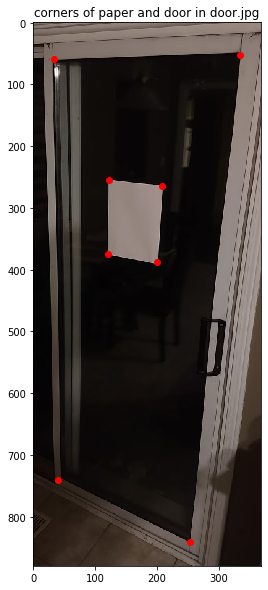

testing if h is correct (the matrix multiplication Ah should give a vector of zeros)
[-2.88657986e-15 -1.51545443e-14  7.14095449e-13  6.60582700e-13
 -5.59552404e-13 -6.81621426e-13  5.07371922e-14  5.02375919e-14]
This vector is very close to the zero vector so our value for h is quite accurate 

The homography transformation matrix, H,  is:
[[-3.24749442e-03  5.45812539e-04 -8.01175929e-01]
 [-2.25199237e-04 -1.70756911e-03 -5.98305915e-01]
 [-4.68696350e-06  5.92125840e-06 -1.15477798e-02]]


The vector form, h, of the homography transformation matrix  is:
[-3.24749442e-03  5.45812539e-04 -8.01175929e-01 -2.25199237e-04
 -1.70756911e-03 -5.98305915e-01 -4.68696350e-06  5.92125840e-06
 -1.15477798e-02]


Difference between corners (the known real-life corners of the paper) and homography_corners (the corners after transforming    the paper in the image):
[[ 0.00000000e+00  1.15107923e-12]
 [ 0.00000000e+00 -6.66489086e-12]
 [ 0.00000000e+00 -3.45323770e-12]
 [ 0.00000000e+00  2.8421

In [28]:
# question 2

# The dimensions of the sheet of paper are 21.59cm x 27.94cm
# actual corners (in cm) if top left corner is at (100, 100):
corners = np.array([[100,100],
                    [121.59,100],
                    [100, 127.94],
                    [121.59, 127.94]
                    ])

# using my harris corner detector (and some trial and error) from assignment 2, I found that the corners of the paper in the picture were:
transformed_corners = np.array([[123,255],
                    [208,264],
                    [121, 375],
                    [200, 387]])

#similarly, I found the door corners:
transformed_door_corners = np.array([[33,59],
                    [334,52],
                    [40, 740],
                    [253, 841]])

# read in the image
door = plt.imread('door.png', 0)[:,:,:3]  # remove any extra channels


# plotting corners:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(door)
plt.title("corners of paper and door in door.jpg")
plt.plot(transformed_corners[:, 0], transformed_corners[:, 1],'ro', markersize=6)
plt.plot(transformed_door_corners[:, 0], transformed_door_corners[:, 1],'ro', markersize=6)
plt.show()


# Solving for homography that r=transforms the paper in the image to the real life paper whose dimensions are known

# convert the matrix equation to the form given by slide 35 of lecture 9
# Ah = 0

n = 4  # number of points (matches)
A = np.zeros((4,2,9))

for i in range(n):
    x = transformed_corners[i][0]   # corners of paper in the image
    y = transformed_corners[i][1]
    x_prime = corners[i][0]         # corners of real paper
    y_prime = corners[i][1]
    
    
    A[i] = np.array([[x, y, 1, 0, 0, 0, -x*x_prime, -y*x_prime, -x_prime],
                     [0, 0, 0, x, y, 1, -x*y_prime, -y*y_prime, -y_prime]])
A = A.reshape((2*n,9))    


#print(A)
#print("\n")


# solve for h
# as per https://math.stackexchange.com/questions/494238/how-to-compute-homography-matrix-h-from-corresponding-points-2d-2d-planar-homog,
# h is the last singular vector of V, where A = US(V^T) (singular value decomposition, V^T is the transpose of V)


u, s, v = np.linalg.svd(A, full_matrices=True)
h = v[-1]




print("testing if h is correct (the matrix multiplication Ah should give a vector of zeros)")
print(np.matmul(A, h))
print("This vector is very close to the zero vector so our value for h is quite accurate \n")


# now that we solved for h, reshape it to get the homography transformation matrix H
H = h.reshape((3,3))
print("The homography transformation matrix, H,  is:")
print(H)
print("\n")


print("The vector form, h, of the homography transformation matrix  is:")
print(h)
print("\n")



# apply homography to corners of paper to double check:
homography_corners = np.zeros(np.shape(transformed_corners))
scale = [0,0,0,0]

for i in range(len(transformed_corners)):
    homography_corners[i] = np.matmul(H, np.concatenate((transformed_corners[i], np.array([1])), axis=None))[:2]
    # Note: the concatenate is used to add a 1 to the vectors to get them in the desired form : [x, y, 1]
    # the matmul is to apply the affine transformation
    # the [:2] is to get rid of the third value in the result of the multiplication (see slide 33, for example)
    
    # the homography_corners won't be to scale, so fix them
    scale[i] = corners[i,0]/homography_corners[i,0]
    if scale[i] == 0:
        scale[i] = corners[i,1]/homography_corners[i,1]
    homography_corners[i] = homography_corners[i]*scale[i]
    
# Testing if the homography is good using the calculated and known corners of the paper
print("Difference between corners (the known real-life corners of the paper) and homography_corners (the corners after transforming    the paper in the image):")
print(homography_corners-corners)
print("The diference between the two arrays of corners is very close to zero meaning that the homography is quite good \n")






# apply homography to corners of door:
door_corners = np.zeros(np.shape(transformed_door_corners))
for i in range(len(transformed_door_corners)):
    door_corners[i] = np.matmul(H, np.concatenate((transformed_door_corners[i], np.array([1])), axis=None))[:2]
    # Note: the concatenate is used to add a 1 to the vectors to get them in the desired form : [x, y, 1]
    # the matmul is to apply the affine transformation
    # the [:2] is to get rid of the third value in the result of the multiplication (see slide 33, for example)
    
    # apply scale:
    door_corners[i] = door_corners[i]*scale[i]    
    
# SCALE IS NOT THE PROBLEM
# MAYBE THE HOMOGRAPHY IS WRONG OR MABE THE APPLICATION IS WRONG




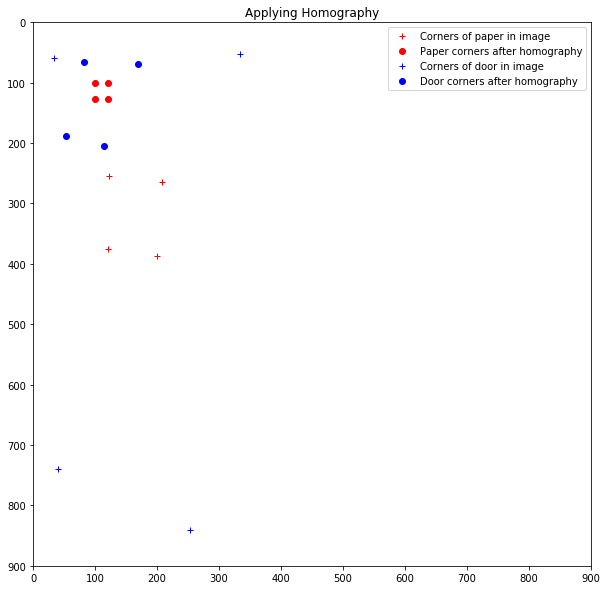

[[ 82.54295884  66.55929989]
 [169.48439858  69.55783687]
 [ 53.27991602 189.08769184]
 [114.16560131 205.16182751]]
[[ 33  59]
 [334  52]
 [ 40 740]
 [253 841]]


In [34]:

# plotting corners:
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.title("corners of door")
plt.plot(transformed_corners[:, 0], transformed_corners[:, 1],'r+', markersize=6, label="Corners of paper in image")
plt.plot(homography_corners[:, 0], homography_corners[:, 1],'ro', markersize=6, label="Paper corners after homography")
plt.plot(transformed_door_corners[:, 0], transformed_door_corners[:, 1],'b+', markersize=6, label="Corners of door in image")
plt.plot(door_corners[:, 0], door_corners[:, 1],'bo', markersize=6, label="Door corners after homography")


plt.title("Applying Homography")
plt.xlim([0,900])
plt.ylim([0,900])
ax.invert_yaxis()
plt.legend(loc="upper right")
plt.show()

print(door_corners)
print(transformed_door_corners)

As shown in the figure above, my code
correctly transforms the paper (the red “+” symbols to the red
circles), which makes me think that I found the correct
homography, but for some reason, the door is not transformed
correctly (the blue “+” symbols to the blue circles). As a result, I
was unable to estimate the dimensions of the door.


In the code below, I use cv2 methods to see if maybe the issue lies in my code.

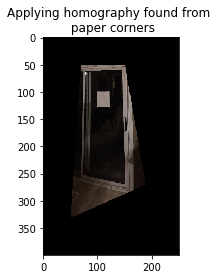

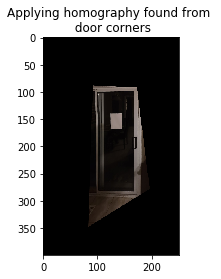

In [31]:
# Finding the homography using the door instead of the paper


# actual corners of paper (in cm) if top left corner is at (100, 100) (so that transformed door is still in the picture):
corners = np.array([[100,100], [121.59,100], [100, 127.94], [121.59, 127.94]])

# using my harris corner detector (and some trial and error) from assignment 2, I found that the corners of the paper in the picture were:
transformed_corners = np.array([[123,255], [208,264], [121, 375], [200, 387]])


# real life door corners
corners2 = np.array([[100,100], [167,100], [100, 283], [167, 283]])

# door corners from the image:
transformed_corners2 = np.array([[33,59], [334,52], [40, 740], [253, 841]])


import cv2
# Find homography using paper
H, mask = cv2.findHomography(transformed_corners, corners)

# Use homography
height, width, channels = door.shape
im1Reg = cv2.warpPerspective(door, H, (250, 400))
plt.imshow(im1Reg)
plt.title("Applying homography found from \n paper corners")
plt.show()



# Find homography using door
H, mask = cv2.findHomography(transformed_corners2, corners2)

# Use homography
height, width, channels = door.shape
im1Reg = cv2.warpPerspective(door, H, (250, 400))
plt.imshow(im1Reg)
plt.title("Applying homography found from \n door corners")
plt.show()


I used the real life corners of the door (I
measured the door) to find the homography (using cv2 methods), and it gave a different homography than when I
used the corners of the paper. The two images above should theoretically be the same, since the paper and
door are on the same plane.
They were calculated with the cv2 methods, so this makes me
think my code is correct and there is some other issue.

My best guess is
that since the door is so much bigger than the paper, the error in
the homography (found using the paper corners) is more visible. If
you look at the second image above, the paper is not mapped
perfectly to a rectangle either, but since it is smaller, the error is
less noticeable.



Also, my homography code (the same code I used for question 2,
not the cv2 functions) seems to work for question 3.